In [85]:
import pandas as pd

In [86]:
data = pd.read_csv('../table_data/cleaned_data.csv')

# Label Encoding

In [87]:
data['NEWS_TYPE'] = data['NEWS_TYPE'].map(lambda x: x.strip(), na_action='ignore')

In [88]:
data['NEWS_TYPE'].unique()

array(['môi giới', 'cá nhân'], dtype=object)

In [5]:
data['NEWS_TYPE'] = data['NEWS_TYPE'].map({'môi giới': 0, 'cá nhân': 1})

In [6]:
data['APARTMENT_TYPE'].unique()

array(['chung cư tập thể', 'chung cư thường', 'chung cư studio',
       'chung cư mini', 'chung cư cao cấp'], dtype=object)

In [7]:
data['APARTMENT_TYPE'] = data['APARTMENT_TYPE'].map({'chung cư tập thể': 0, 'chung cư thường': 1, 'chung cư studio': 2,
                                                     'chung cư mini': 3, 'chung cư cao cấp': 4})

In [8]:
data['FURNITURE_TYPE'].unique()

array(['unk', 'full', 'cơ bản', 'full cao cấp', 'nguyên bản'],
      dtype=object)

In [9]:
data['FURNITURE_TYPE'] = data['FURNITURE_TYPE'].map({'unk': 0, 'full': 1, 'cơ bản': 2,
                                                     'full cao cấp': 3, 'nguyên bản': 4})

In [10]:
data.drop('BATH_ROOM_NUMBER', inplace=True, axis=1)

In [11]:
data

,NEWS_TYPE,BEDROOM_NUMBER,AREA,APARTMENT_TYPE,FURNITURE_TYPE,PRICE,LATITUDE,LONGITUDE
0,0,3.0,80.0,0,0,7.5,21.041731,105.809950
1,1,2.0,48.0,1,0,7.5,21.008615,105.834091
2,1,1.0,40.0,0,0,5.0,20.999548,105.860602
3,0,1.0,30.0,2,1,4.5,21.032594,105.808742
4,0,1.0,30.0,1,1,4.5,21.033861,105.809472
...,...,...,...,...,...,...,...,...
15835,0,2.0,80.0,1,0,8.0,20.995910,105.857653
15836,0,2.0,80.0,1,1,7.0,21.032950,105.761765
15837,0,2.0,80.0,1,0,8.0,21.061711,105.894487
15838,0,2.0,85.0,1,2,25.0,21.032237,105.833055


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
y = data['PRICE']
X = data.drop('PRICE', axis=1)

In [14]:
len(data)

15840

# Split train/val/test set

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=42)

In [17]:
len(X_train), len(X_val), len(X_test)

(11088, 3183, 1569)

# Random Forest Model and Random Search Hyperparamters

In [18]:
import numpy as np

n_estimators = np.arange(20, 150, step=10)
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 100, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = np.arange(2, 10, step=2)
bootstrap = [True, False]

In [19]:
param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

random_cv = RandomizedSearchCV(
    forest, param_grid, n_iter=80, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)

In [20]:
X_train_tune, X_test_tune, y_train_tune, y_test_tune = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
_ = random_cv.fit(X_train_tune, y_train_tune)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [30]:
print("Best params:")
print(random_cv.best_params_)

Best params:
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


In [71]:
best_model = RandomForestRegressor(**random_cv.best_params_)

In [72]:
best_model.set_params(**{'random_state': 42})

RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=40,
                      random_state=42)

In [73]:
best_model.fit(X_train_tune, y_train_tune)

RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=40,
                      random_state=42)

In [74]:
best_model.score(X_train_tune, y_train_tune)

0.9045713039117484

In [75]:
best_model.score(X_test_tune, y_test_tune)

0.7321362439008773

# Inference

In [79]:
best_model.predict(X_test_tune.iloc[1].values.reshape(1, -1))

array([5.1622381])

In [80]:
X_test_tune.iloc[1]

NEWS_TYPE           0.000000
BEDROOM_NUMBER      1.000000
AREA               40.000000
APARTMENT_TYPE      3.000000
FURNITURE_TYPE      1.000000
LATITUDE           21.010563
LONGITUDE         105.799422
Name: 169, dtype: float64

In [81]:
y_test_tune.iloc[1]

5.5

# Save model

In [82]:
import joblib

joblib.dump(best_model, 'model/best_random_forest.joblib')

['model/best_random_forest.joblib']

# Visualize feature importance

In [99]:
importances = best_model.feature_importances_

In [100]:
features = list(X_train_tune.columns)

In [101]:
features

['NEWS_TYPE',
 'BEDROOM_NUMBER',
 'AREA',
 'APARTMENT_TYPE',
 'FURNITURE_TYPE',
 'LATITUDE',
 'LONGITUDE']

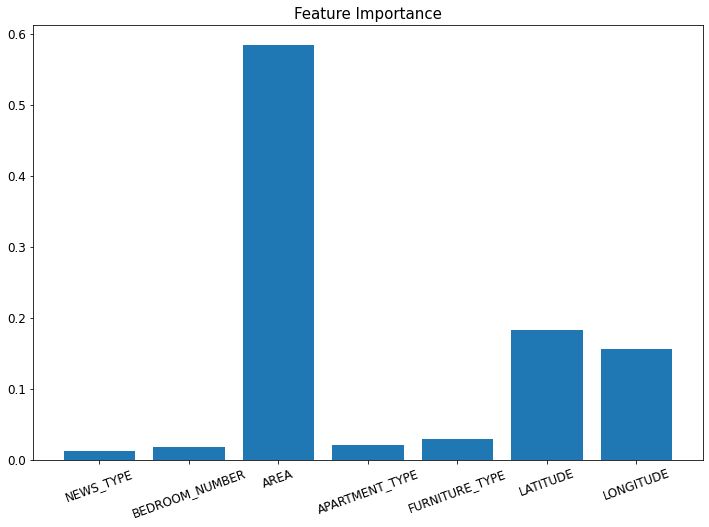

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances)
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), features, rotation=20, fontsize = 12)
plt.yticks(fontsize=12)
# Create plot title
plt.title("Feature Importance", fontsize=15)
# Show plot
plt.show()

In [111]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgboost_model = XGBRegressor()
scores = cross_val_score(xgboost_model, X_train_tune, y_train_tune, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [112]:
from numpy import absolute
scores = absolute(scores)

In [113]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 1.527 (0.034)


In [115]:
yhat = xgboost_model.predict(X_test_tune)

NotFittedError: need to call fit or load_model beforehand